In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd

In [11]:
def CTfunction(a, glauert = False):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT
  
    
def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot

def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm,vtan)
    alpha = twist + inflowangle*180/np.pi
    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5*vmag2*cl*chord
    drag = 0.5*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*np.sqrt(vmag2)*cl*chord
    return fnorm , ftan, gamma, alpha, inflowangle*180/np.pi, cl, cd, vmag2

def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd ):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    Uinf - wind speed at infinity
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    # initiatlize variables
    a = 0.0 # axial induction
    aline = 0.0 # tangential induction factor
    
    Niterations = 1000
    Erroriterations =0.00001 # error limit for iteration rpocess, in absolute value of induction
    
    for i in range(Niterations):
        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate velocity and loads at blade element"
        # ///////////////////////////////////////////////////////////////////////
        Urotor = Uinf*(1-a) # axial velocity at rotor
        Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
        # calculate loads in blade segment in 2D (N/m)
        fnorm, ftan, gamma, alpha, inflowangle, cl, cd, vmag2 = loadBladeElement(Urotor, Utan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd)
        load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
        # load3Dtan =loads[1]*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)
      
        # ///////////////////////////////////////////////////////////////////////
        # //the block "Calculate velocity and loads at blade element" is done
        # ///////////////////////////////////////////////////////////////////////

        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        # // calculate thrust coefficient at the streamtube 
        CT = load3Daxial/(0.5*Area*Uinf**2)
        
        # calculate new axial induction, accounting for Glauert's correction
        anew =  ainduction(CT)
        
        # correct new axial induction with Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/Uinf, NBlades, anew);
        if (Prandtl < 0.0001): 
            Prandtl = 0.0001 # avoid divide by zero
        anew = anew/Prandtl # correct estimate of axial induction
        a = 0.85*a+0.15*anew # for improving convergence, weigh current and previous iteration of axial induction

        # calculate aximuthal induction
        aline = ftan*NBlades/(2*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
        aline =aline/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
        # ///////////////////////////////////////////////////////////////////////////
        # // end of the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        
        #// test convergence of solution, by checking convergence of axial induction
        if (np.abs(a-anew) < Erroriterations): 
            # print("iterations")
            # print(i)
            break
    if i == Niterations-1:
        print('WARNING: BEM model did not converge within {} iterations, consider increasing iteration amount.'.format(Niterations))
    # Force coefficients. Ct has already been calculated
    CN = 0 
    CQ = 0
    return [a , aline, r_R, fnorm , ftan, gamma, alpha, inflowangle, CT, CN, CQ, cl, cd]

# Turbine

In [12]:
"""
Class to initiate a BEM model of which the chord and twist distributions can be updated
Inputs:
- airfoil                                 (DU_polar.txt or ARA_polar.txt)
- TipLocation_R                           (The normalized radial location of the tip)
- RootLocation_R                          (The normalized radial location of the root)
- NBlades                                 (The number of blades)
- Radius                                  (The radius of the rotor)
- Uinf                                    (The freestream velocity)
- TSR                                     (The tip speed ratio)
- delta_r_R                               (The step in radial direction for each annulus)
- CT_opt                                  (The Thrust Coefficient to optimize for)
"""

class BEM_model:
    def __init__(self,airfoil,TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, TSR, delta_r_R, CT_opt):
        self.airfoil = airfoil
        self.TipLocation_R = TipLocation_R
        self.RootLocation_R = RootLocation_R
        self.NBlades = NBlades
        self.Radius = Radius
        self.Uinf = Uinf
        self.Omega = Uinf*TSR/Radius
        self.delta_r_R = delta_r_R
        self.CT_opt = CT_opt
        
        #initialize the starting pitch
        self.pitch = 2
        
        #initialize the normalized radial locations each annulus
        self.r_R = np.arange(RootLocation_R, 1+delta_r_R/2, delta_r_R)
        
        #read in the airfoil polars
        data1=pd.read_csv(airfoil, header=0,
                    names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
        self.polar_alpha = data1['alfa'][:]
        self.polar_cl = data1['cl'][:]
        self.polar_cd = data1['cd'][:]
                  
        #initialize a empty iteration history list, a cp history list and set the iteration number to zero
        self.iteration_history = []
        self.cp_history = []
        self.coef_history = []
        self.iteration_number = 0            
    
    #function to update the chord distribution, can be a polynomial of any order
    def update_chord_dist(self,coef):
        self.chord_distribution = np.polynomial.polynomial.polyval(self.r_R, coef)
    
    #function to update the twist distribution, can be a polynomial of any order
    def update_twist_nopitch_dist(self,coef):
        self.twist_distribution_nopitch = np.polynomial.polynomial.polyval(self.r_R, coef)
    
    #function to solve the model given a certain pitch, returns the CT, CP and the results
    #from the function solveStreamtube
    def find_CP_CT(self,pitch):
        #add the given pitch to the current twist distribution
        twist_distribution = self.twist_distribution_nopitch + pitch
        
        # solve BEM model
        results =np.zeros([len(self.r_R)-1,13]) 
        for i in range(len(self.r_R)-1):
            chord = np.interp((self.r_R[i]+self.r_R[i+1])/2, self.r_R, self.chord_distribution)
            twist = np.interp((self.r_R[i]+self.r_R[i+1])/2, self.r_R, twist_distribution)

            results[i,:] = solveStreamtube(self.Uinf, self.r_R[i], self.r_R[i+1], self.RootLocation_R, self.TipLocation_R , self.Omega, self.Radius, self.NBlades, chord, twist, self.polar_alpha, self.polar_cl, self.polar_cd )
        
        #calculate the areas of the stream tubes at the rotor
        areas = (self.r_R[1:]**2-self.r_R[:-1]**2)*np.pi*self.Radius**2
        #find the radial step of each streamtube (is only different in the case of a non-uniform spacing)
        dr = (self.r_R[1:]-self.r_R[:-1])*self.Radius
        #Find the CT and CP
        CT = np.sum(dr*results[:,3]*self.NBlades/(0.5*self.Uinf**2*np.pi*self.Radius**2))
        CP = np.sum(dr*results[:,4]*results[:,2]*self.NBlades*self.Radius*self.Omega/(0.5*self.Uinf**3*np.pi*self.Radius**2))

        return CT, CP, results
    
    #function to find the CP of the current cofiguration for the given CT_opt
    def find_cp(self):
        # initialize the pitch
        pitch_0 = self.pitch # degrees
        
        #set how far the result may differ from the CT_opt
        epsilon = 0.0001
        
        #set the step for calculating the numerical derivatives
        h = epsilon*0.01
        
        #initialize the current pitch
        current_pitch = pitch_0
        
        #set the values for the pitch to calculate the derivatives
        dh_pitch_plus = current_pitch+h
        dh_pitch_min = current_pitch-h
        
        #initialize a very large value for the CT
        CT = 999999
        
        #set a variable to check for the number of iterations
        check_iter = 0
        
        while abs(CT-self.CT_opt)>epsilon:
            #save the previous value to be able to see if the error is diverging
            check_prev = abs(CT-self.CT_opt)
            
            #find the CT for the current pitch
            CT,CP,results = self.find_CP_CT(current_pitch)
            
            #find the CT for the pitches around the point to be able to calculate the derivative
            CT_plus, CP_plus, _ = self.find_CP_CT(dh_pitch_plus)
            CT_min, CP_min, _ = self.find_CP_CT(dh_pitch_min)
            
            #calculate the derivative with a central difference scheme
            deriv = (CT_plus-CT_min)/(2*h)
            
            #update the pitch using the Newton-Rhapson method
            current_pitch = current_pitch - (CT-self.CT_opt)/(deriv)    
            
            #set the saved pitch to the current pitch
            self.pitch = current_pitch
            
            check_iter += 1
            
            #if it takes longer than 10 iterations, notify the user             
            if check_iter >10:
                print('WARNING: The number of iterations to find the pitch with correct CT is exceeding 10')
                print('Current CT = {}'.format(CT))
            
            #if the error is diverging, notify the user
            if abs(CT-self.CT_opt) > check_prev:
                print('WARNING: The error is diverging')
        #return the current solution
        return CT,CP,results
    
    #function to calculate the jacobian matrix wrt. the coefficients of the chord and twist distribution
    #note that the first halve of the coefficient vector, are the coefficients for the chord distribution
    #and the second the coefficients for the twist distribution
    def calculate_jac(self,coefficient_vector):
        #step to calculate the derivatives
        h = 0.001
        
        #find the middle of the coefficient vector
        index = int(len(coefficient_vector)/2)
        
        #initialize the results        
        jacobian = np.zeros(len(coefficient_vector))
        
        #for each coefficient in the coefficient vector, calculate the gradient
        for i in range(len(coefficient_vector)):
            #subtract or add the h from the correct coefficient
            h_vec = np.zeros(len(coefficient_vector))
            h_vec[i] = h
            
            #find cp for the minus h part
            coeff_min = coefficient_vector - h_vec
            #update the current chord and twist distributions and find the cp
            self.update_chord_dist(coeff_min[:index])
            self.update_twist_nopitch_dist(coeff_min[index:])
            CT,CP_hmin,_ = self.find_cp()
            
            
            #find cp for the plus h part
            coeff_plus = coefficient_vector + h_vec
            #update the current chord and twist distributions and find the cp
            self.update_chord_dist(coeff_plus[:index])
            self.update_twist_nopitch_dist(coeff_plus[index:])
            CT,CP_hplus,_ = self.find_cp()

            #find the value of the Jacobian for this i by calculating the gradient
            jacobian[i] = (CP_hplus-CP_hmin)/(2*h)

        #note that the function to minimize is -Cp, meaning the jacobian
        #needs to reflect this
        return -1*jacobian
    
    #the function which needs to be minimized
    def function_to_minimize(self, coefficient_vector):
        #find the chord and twist coefficients
        coef_chord = coefficient_vector[:int(len(coefficient_vector)/2)]
        coef_twist = coefficient_vector[int(len(coefficient_vector)/2):]
        
        #update the chord and twist distributions
        self.update_chord_dist(coef_chord)
        self.update_twist_nopitch_dist(coef_twist)
        
        #find the CP
        CT,CP,results = self.find_cp()
        
        #add the iteration number to the iteration history list
        self.iteration_history.append(self.iteration_number)
        
        #append the CP to the cp history
        self.cp_history.append(CP)
        self.coef_history.append(coefficient_vector)
        
        #call a function to update the plot
        self.update_plot()
        
        #add an iteration to the iteration number
        self.iteration_number += 1
        
        #note that gradient descent tries to minimize, meaning we need to return
        #negative CP
        return -1*CP
    
    #function to update the plots of the cp history and current distributions
    def update_plot(self):
        clear_output(wait=True)
        plt.figure(1)
        plt.plot(self.iteration_history,self.cp_history)
        plt.grid(True)
        plt.xlabel('Iteration Number [-]')
        plt.ylabel(r'C_P [-]')
        plt.title('Power Coefficient history')
        
        plt.figure(2)
        plt.plot(self.r_R,self.chord_distribution)
        plt.grid(True)
        plt.xlabel('r/R [-]')
        plt.ylabel('Chord [m]')
        plt.title('Current Chord distribution')

        plt.figure(3)
        plt.plot(self.r_R,self.twist_distribution_nopitch)
        plt.grid(True)
        plt.xlabel('r/R [-]')
        plt.ylabel('Twist [deg]')
        plt.title('Current twist distribution')
        
        plt.show()
    
    def results_for_d(self, coefficient_vector, pitch, show_fig=False, save_fig=False):
        #find the middle of the coefficient vector
        index = int(len(coefficient_vector)/2)

        #update the current chord and twist distributions and find the cp
        self.update_chord_dist(coefficient_vector[:index])
        self.update_twist_nopitch_dist(coefficient_vector[index:])
        twist_distribution = self.twist_distribution_nopitch + pitch
        
        # solve BEM model
        results =np.zeros([len(self.r_R)-1, 13]) 
        for i in range(len(self.r_R)-1):
            chord = np.interp((self.r_R[i]+self.r_R[i+1])/2, self.r_R, self.chord_distribution)
            twist = np.interp((self.r_R[i]+self.r_R[i+1])/2, self.r_R, twist_distribution)
            
            # result columns: [a , aline, r_R, fnorm , ftan, gamma, alpha, inflowangle, CT, CN, CQ]
            results[i,:] = solveStreamtube(self.Uinf, self.r_R[i], self.r_R[i+1], self.RootLocation_R, self.TipLocation_R , self.Omega, self.Radius, self.NBlades, chord, twist, self.polar_alpha, self.polar_cl, self.polar_cd )
        
        # Area per annulus
        dArea = np.pi*(self.r_R[1:]**2-self.r_R[:-1]**2)*self.Radius**2
        
        # [a , aline, r_R, fnorm , ftan, gamma, alpha, inflowangle, CT, CN, CQ]
        # CT = fnorm*Radius*(r2_R-r1_R)*NBlades/(0.5*Area*Uinf**2)
        results[:,8] = results[:,3]*(self.r_R[1:]-self.r_R[:-1])*self.Radius*self.NBlades/(0.5*self.Uinf**2*dArea)
        results[:,9] = results[:,4]*(self.r_R[1:]-self.r_R[:-1])*self.Radius*self.NBlades/(0.5*self.Uinf**2*dArea)
        results[:,10] = results[:,2]*results[:,3]*(self.r_R[1:]-self.r_R[:-1])*self.Radius*self.NBlades/(0.5*self.Uinf**2*dArea)
        
        if show_fig==True:
            # plots the inflow angle and the angle of attack w.r.t. r/R
            fig1 = plt.figure(figsize=(12, 6))
            plt.title('AoA and Inflow angles')
            plt.plot(results[:,2], results[:,6], 'g--', label='alpha')
            plt.plot(results[:,2], results[:,7], 'b--', label='inflow angle')
            plt.grid(True)
            plt.xlabel('r/R [-]')
            plt.ylabel('angle [deg]')
            plt.legend()

            # plots the induction factors a, a' w.r.t. r/R
            fig2 = plt.figure(figsize=(12, 6))
            plt.title('Induction Factors')
            plt.plot(results[:,2], results[:,0], 'g--', label='a')
            plt.plot(results[:,2], results[:,1], 'b--', label='a_prime')
            plt.grid(True)
            plt.xlabel('r/R')
            plt.legend()

            # plots the force coefficients Ct, Cn, Cq w.r.t. r/R
            fig3 = plt.figure(figsize=(12, 6))
            plt.title('Force coefficients')
            plt.plot(results[:,2], results[:,8], 'g--', label='Ct')
            plt.plot(results[:,2], results[:,9], 'r--', label='Cn')
            plt.plot(results[:,2], results[:,10], 'b--', label='Cq')
            plt.grid(True)
            plt.xlabel('r/R')
            plt.legend()
            
            plt.show()

            if save_fig==True:
                fig1.savefig('{}_alpha_inflow_r_R.png'.format(self.airfoil.split('.')[0]))
                fig2.savefig('{}_a_aprime_r_R.png'.format(self.airfoil.split('.')[0]))
                fig3.savefig('{}_Ct_Cn_Cq_r_R.png'.format(self.airfoil.split('.')[0]))

        return results


In [30]:
airfoil = 'DU_polar.txt'

data1=pd.read_csv(airfoil, header=0,
                    names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
polar_alpha = data1['alfa'][:]
polar_cl = data1['cl'][:]
polar_cd = data1['cd'][:]

# define the blade geometry
delta_r_R = .01
r_R = np.arange(0.2, 1+delta_r_R/2, delta_r_R)

chord_distribution = 2.94328554 -2.44194009*(r_R)
twist_distribution = -6.36361491 + 12.8540052*(r_R) -1.2769146321873894

twist_distribution_8 = -2.88705282 + 15.58259799*(r_R) -7.948513045376299
chord_distribution_8 = 4.46539469 -3.69564252*(r_R) 

TSR_8 = 8
TSR = 10
# define flow conditions
U_0 = 10 # unperturbed wind speed in m/s
Uinf= 10
Radius = 50
Omega8 = U_0*TSR_8/Radius
Omega10 = U_0*TSR/Radius
NBlades = 3

TipLocation_R =  1
RootLocation_R =  0.2

results8 =np.zeros([len(r_R)-1,13]) 
results10 =np.zeros([len(r_R)-1,13]) 

for i in range(len(r_R)-1):
    chord = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution)
    twist = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution) 
    chord_8 = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution_8)
    twist_8 = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution_8) 

    results8[i,:] = solveStreamtube(U_0, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega8, Radius, NBlades, chord_8, twist_8, polar_alpha, polar_cl, polar_cd )
    results10[i,:] = solveStreamtube(U_0, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega10, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd )

# plot results

areas = (r_R[1:]**2-r_R[:-1]**2)*np.pi*Radius**2
dr = (r_R[1:]-r_R[:-1])*Radius

CT = np.sum(dr*results10[:,3]*NBlades/(0.5*Uinf**2*np.pi*Radius**2))
CP = np.sum(dr*results10[:,4]*results10[:,2]*NBlades*Radius*Omega10/(0.5*Uinf**3*np.pi*Radius**2))

print("CT for TSR = 10 is ", CT)
print("CP for TSR = 10 is ", CP)

CT_8 = np.sum(dr*results8[:,3]*NBlades/(0.5*Uinf**2*np.pi*Radius**2))
CP_8 = np.sum(dr*results8[:,4]*results8[:,2]*NBlades*Radius*Omega8/(0.5*Uinf**3*np.pi*Radius**2))

print("CT for TSR = 8 is:", CT_8)
print("CP for TSR = 8 is:", CP_8)

CT for TSR = 10 is  0.750000001203795
CP for TSR = 10 is  0.4770802282624446
CT for TSR = 8 is: 0.7499999989393897
CP for TSR = 8 is: 0.4783530997186238


In [31]:
%store results8
%store results10
%store chord
%store dr
%store r_R

Stored 'results8' (ndarray)
Stored 'results10' (ndarray)
Stored 'chord' (float64)
Stored 'dr' (ndarray)
Stored 'r_R' (ndarray)


# Class for creating plots

In [4]:
# Initialize the constants
class CreatePlots():
    def __init__(self):
        self.coefficients = []
        self.airfoil = 'DU_polar.txt'
        self.delta_r_R = .01
        self.Uinf = 10 # unperturbed wind speed in m/s
        self.TSR = 8 # tip speed ratio
        self.Radius = 50
        self.NBlades = 3

        self.TipLocation_R =  1
        self.RootLocation_R =  0.2

        self.CT_opt = 0.75

        # Initialize the model
        
        self.B = BEM_model(self.airfoil, self.TipLocation_R, self.RootLocation_R, self.NBlades, 
                           self.Radius, self.Uinf, self.TSR, self.delta_r_R, self.CT_opt)
        
        self.coef0 = np.array([1*4, -3, -14*0.5, 0.5*14])
        
    def optimize(self, TSR):
        
        self.B.TSR = TSR
        #intitial learning rate
        gamma = 0.01

        #initialize the current and previous coefficients
        current_coef = 1*self.coef0
        prev_coef = 1*self.coef0

        #intialize the coefficient history
        coef_history = []
        CP_history = []
        pitch_history = []

        #set the number of iterations to do, can also be changed to convergence criterium
        for i in range(100):
            print('The current coefficients used are: {}'.format(current_coef))

            #if we are not in the first iteration loop, save the previous jacobian matrix
            if i != 0:
                prev_jac = 1*jac 

            #calculate the current jacobian matrix
            jac = B.calculate_jac(current_coef) 

            #find the current CP
            current_cp = self.B.function_to_minimize(current_coef) 
            print('Of which the CP has the value: {}'.format(-1*current_cp))

            coef_history.append(current_coef)
            CP_history.append(-1*current_cp)
            pitch_history.append(self.B.pitch)

            #calculate learning rate using the Barzilai-Borwein method
            if i!=0:
                gamma =abs(np.sum((current_coef-prev_coef)*(jac-prev_jac)))/(np.sum((jac-prev_jac)**2))

                #cap the learning rate to a certain value to prevent the algorithm from stepping too far
                #to a non-physical situation
                if gamma > 50:
                    gamma = 50

                print('The learning rate for this step is: {}'.format(gamma))
                #save the value for the previous coefficients to be able to calculate the learning 
                #rate in the next step
                prev_coef = 1*current_coef 

            #update the coefficients by stepping in the opposite direction of the gradient
            current_coef = current_coef-gamma*jac 

            #check if the new coefficients cause the chord distribution to be negative anywhere:

            chord_dist = np.polynomial.polynomial.polyval(self.B.r_R, current_coef[:int(len(current_coef)/2)])
            chord_value_check = min(chord_dist)

            if chord_value_check <= 0:
                #if this is the case, make sure the minimum value of the chord is 0.1 by 
                #shifting the polynomial up.
                print(chord_value_check)

                current_coef[0] = current_coef[0] + abs(chord_value_check) + 0.1 
            
        # get the results for this TSR
        index_max = np.argmax(CP_history)
        results = self.B.results_for_d(current_coef, pitch_history[index_max])
        self.coefficients.append([TSR, pitch_history[index_max], current_coef])
        
        #print the current coefficient set after the iterations are done   
        return [TSR, results, coef_history, CP_history, pitch_history]
    
    def run(self, TSR_range):
        """ Runs the optimization for all tsr ranges """
        result_list = []
        history = []
        for TSR in TSR_range:
            TSR, results, coef_history, CP_history, pitch_history = self.optimize(TSR)
            result_list.append([TSR, results])
            history.append([TSR, coef_history, CP_history, pitch_history])
        return result_list, history
    
    def plot(self, result_list):
        # plots the inflow angles and the angles of attack w.r.t. r/R
        fig1 = plt.figure(figsize=(12, 6))
        plt.title('AoA and inflow angles')
        x = np.arange(1,10,1)
        colors = ['g','b','r']
        airfoil = 'DU_polar.txt'

        for i, j in enumerate(result_list):
            results=j[1]
            plt.plot(results[:,2], results[:,6], c=colors[i], linestyle='-', label='alpha for TSR={}'.format(j[0]))
            plt.plot(results[:,2], results[:,7], c=colors[i], linestyle='--', label='inflow angle for TSR={}'.format(j[0]))
        plt.grid(True)
        plt.xlabel('r/R [-]')
        plt.ylabel('angle [deg]')
        plt.legend()
        fig1.savefig('{}_alpha_inflow_r_R.png'.format(airfoil.split('.')[0]))

        # plots the induction factors a, a' w.r.t. r/R
        fig2 = plt.figure(figsize=(12, 6))
        plt.title('Induction factors')
        for i, j in enumerate(result_list):
            results=j[1]
            plt.plot(results[:,2], results[:,0], c=colors[i], linestyle='-', label='a for TSR={}'.format(j[0]))
            plt.plot(results[:,2], results[:,1], c=colors[i], linestyle='--', label='a_prime for TSR={}'.format(j[0]))
        plt.grid(True)
        plt.xlabel('r/R')
        plt.legend()
        fig2.savefig('{}_a_aprime_r_R.png'.format(airfoil.split('.')[0]))

        # plots the force coefficients Ct, Cn, Cq w.r.t. r/R
        fig3 = plt.figure(figsize=(12, 6))
        plt.title('Force coefficients')
        for i, j in enumerate(result_list):
            results=j[1]
            plt.plot(results[:,2], results[:,8], c=colors[i], linestyle='-', label='Ct for TSR={}'.format(j[0]))
            plt.plot(results[:,2], results[:,9], c=colors[i], linestyle='--', label='Cn for TSR={}'.format(j[0]))
            plt.plot(results[:,2], results[:,10], c=colors[i], linestyle=':', label='Cq for TSR={}'.format(j[0]))
        plt.grid(True)
        plt.xlabel('r/R')
        plt.legend()
        fig3.savefig('{}_Ct_Cn_Cq_r_R.png'.format(airfoil.split('.')[0]))
        return result_list   




    


In [5]:
c = CreatePlots()


In [8]:
# result columns: [a , aline, r_R, fnorm , ftan, gamma, alpha, inflowangle, CT, CN, CQ]
#results, history = c.run([8, 10])


The current coefficients used are: [ 4. -3. -7.  7.]


NameError: name 'B' is not defined

In [9]:
dArea = np.pi*(c.B.r_R[1:]**2-c.B.r_R[:-1]**2)*c.B.Radius**2
# [a , aline, r_R, fnorm , ftan, gamma, alpha, inflowangle, CT, CN, CQ]

results[0][1][:,9] = results[0][1][:,4]*(c.B.r_R[1:]-c.B.r_R[:-1])*c.B.Radius*c.B.NBlades/(0.5*c.B.Uinf**2*dArea)
results[1][1][:,9] = results[1][1][:,4]*(c.B.r_R[1:]-c.B.r_R[:-1])*c.B.Radius*c.B.NBlades/(0.5*c.B.Uinf**2*dArea)

new_res = p.plot(results)
p = CreatePlots()

res = p.plot(results)

NameError: name 'results' is not defined

# Lift and drag coefficient distribution

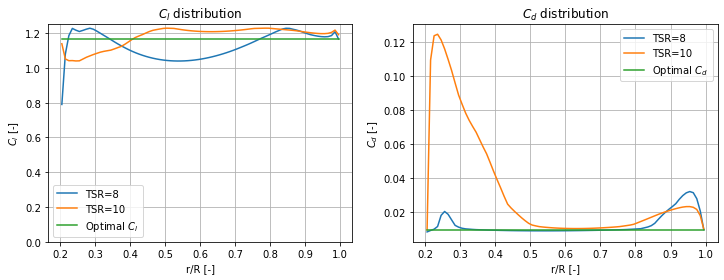

In [198]:
def cl_cd_plots(c, history):
    airfoil = 'DU.txt'
    opt_cl = 1.168
    opt_cd = 0.00994
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    clear_output(wait=True)
    for i in history:
        TSR, coef_history, CP_history, pitch_history = i
        index = np.argmax(CP_history)
        coef = coef_history[-1]
        pitch = pitch_history[index]

        results = c.B.results_for_d(coefficient_vector=coef, pitch=pitch)
        axs[0].plot(results[:,2], results[:,11], label='TSR={}'.format(TSR))
    axs[0].plot(results[:,2], opt_cl*np.ones(len(results[:,2])), label='Optimal '+  r'$C_l$')
    axs[0].grid(True)
    axs[0].set_ylim(bottom=0)
    axs[0].set_xlabel('r/R [-]')
    axs[0].set_ylabel(r'$C_l$ [-]')
    axs[0].set_title(r'$C_l$' + ' distribution')
    axs[0].legend()

    for i in history:
        TSR, coef_history, CP_history, pitch_history = i
        index = np.argmax(CP_history)
        coef = coef_history[-1]
        pitch = pitch_history[index]

        results = c.B.results_for_d(coefficient_vector=coef, pitch=pitch)
        axs[1].plot(results[:,2], results[:,12], label='TSR={}'.format(TSR))
    axs[1].plot(results[:,2], opt_cd*np.ones(len(results[:,2])), label='Optimal '+  r'$C_d$')

    axs[1].grid(True)
    axs[1].set_xlabel('r/R [-]')
    axs[1].set_ylabel(r'$C_d$ [-]')
    axs[1].set_title(r'$C_d$' + ' distribution')
    axs[1].legend()
    fig.savefig('{}_CL_CD distribution.png'.format(airfoil.split('.')[0]))


    plt.show()
    return None
#[TSR, coef_history, CP_history, pitch_history]
cl_cd_plots(c, history)


In [155]:
len(history[0][1])

100

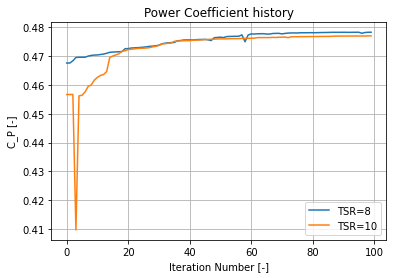

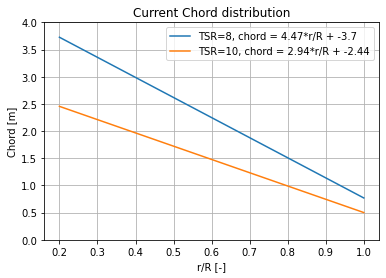

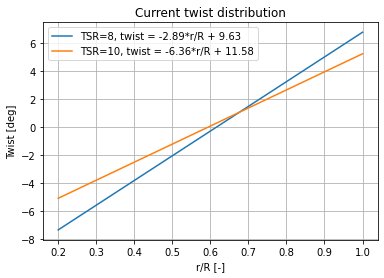

In [142]:

def blade_shape(c, history):
    airfoil = 'DU.txt'
    clear_output(wait=True)
    fig1 = plt.figure(1)
    for i in history:
        TSR, coef_history, CP_history, pitch_history = i
        plt.plot(np.arange(0,len(CP_history),1) , CP_history, label='TSR={}'.format(TSR))
    plt.grid(True)
    plt.xlabel('Iteration Number [-]')
    plt.ylabel(r'C_P [-]')
    plt.title('Power Coefficient history')
    plt.legend()
    fig1.savefig('{}_power_coefficient_history.png'.format(airfoil.split('.')[0]))

    fig2 = plt.figure(2)
    max_chord = 0
    for i in history:
        TSR, coef_history, CP_history, pitch_history = i
        index = np.argmax(CP_history)
        chord = coef_history[-1][0:2]
        chord_dist = np.polynomial.polynomial.polyval(c.B.r_R, chord)
        if max_chord < max(chord_dist):
            max_chord = max(chord_dist)
        plt.plot(c.B.r_R, chord_dist, label='TSR={}, chord = {}*r/R + {}'.format(TSR, round(chord[0],2), round(chord[1], 2)))
    plt.grid(True)
    plt.xlabel('r/R [-]')
    plt.ylabel('Chord [m]')
    plt.ylim((0, np.ceil(max_chord)))
    plt.legend()
    plt.title('Current Chord distribution')
    fig2.savefig('{}_chord distribution.png'.format(airfoil.split('.')[0]))

    fig3 = plt.figure(3)
    for i in history:
        TSR, coef_history, CP_history, pitch_history = i
        index = np.argmax(CP_history)
        twist = coef_history[index][2:]
        pitch = pitch_history[index]
        twist_distribution = np.polynomial.polynomial.polyval(c.B.r_R, twist)+pitch
        plt.plot(c.B.r_R, twist_distribution, label='TSR={}, twist = {}*r/R + {}'.format(TSR, round(twist[0],2), round(twist[1]+pitch, 2)))
    plt.grid(True)
    plt.xlabel('r/R [-]')
    plt.ylabel('Twist [deg]')
    plt.legend()
    plt.title('Current twist distribution')
    fig3.savefig('{}_twist_distribution.png'.format(airfoil.split('.')[0]))

    plt.show()
blade_shape(c, history)

# Comparison to disk theory

In [217]:
for i in results:
    a = sum(i[1][:,0]*(c.B.r_R[1:]-c.B.r_R[:-1]))/(sum((c.B.r_R[1:]-c.B.r_R[:-1])))
    print('a = ', round(a, 4), ' for TSR = ', i[0])
    Ct = round(4*a*(1-a), 4)
    Cp = round(4*a*(1-a)**2, 4)
    print('Actuator disk: Ct ={}, CP = {}'.format(Ct, Cp))
for i in history:
    print('cp = ', round(max(i[2]), 4), ' for TSR = ', i[0])

a =  0.3144  for TSR =  8
Actuator disk: Ct =0.8623, CP = 0.5911
a =  0.3049  for TSR =  10
Actuator disk: Ct =0.8478, CP = 0.5893
cp =  0.4783  for TSR =  8
cp =  0.4771  for TSR =  10


In [212]:
max(history[0][2])

[0.4676335497427181,
 0.46764237981595713,
 0.4684055591773382,
 0.4695712959864127,
 0.46964889757653566,
 0.469658250480973,
 0.4696650750013383,
 0.4700575052758655,
 0.47028396023523633,
 0.47041652291215336,
 0.4704571495142581,
 0.47060890085674484,
 0.4707644893025933,
 0.47102766116419825,
 0.47136985364716,
 0.4714650854552753,
 0.47151147415884154,
 0.4715616369363666,
 0.4716164854685353,
 0.4726151340703558,
 0.4726627831572481,
 0.4728496774387059,
 0.4729127476683827,
 0.4729857617553007,
 0.4730546395573988,
 0.47316650069415767,
 0.4732842479878967,
 0.47344737508383117,
 0.4735253559046887,
 0.47366506852669454,
 0.473840394552143,
 0.47434855477833693,
 0.4745301969748884,
 0.47468995902037603,
 0.4747323368551651,
 0.47478623180366186,
 0.475385922090757,
 0.47546109262826897,
 0.47564485184545735,
 0.4756697510628621,
 0.4756719253590211,
 0.47567444217489396,
 0.4757530549402676,
 0.475818768517297,
 0.47583949275456816,
 0.47585251579435306,
 0.47571362681319995,
